In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.utils import load_dataset
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from art.attacks.evasion import SquareAttack, FastGradientMethod
from keras.utils import to_categorical
from art.defences.detector.evasion import BinaryInputDetector
from sklearn.metrics import accuracy_score
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import TensorFlowV2Classifier
from art.defences.preprocessor import SpatialSmoothing
from sklearn.metrics import precision_score

%matplotlib inline

tf.compat.v1.disable_eager_execution()

In [3]:
model1 = tf.keras.models.load_model('lab6')

In [4]:
df = pd.DataFrame(columns=['Family', 'Image'])
fam_cat = {}
for i, family in enumerate(os.listdir('malimg_paper_dataset_imgs')):
    fam_cat[i] = family
    for image in os.listdir(f'malimg_paper_dataset_imgs/{family}'):
        imagen = Image.open(f'malimg_paper_dataset_imgs/{family}/{image}')
        imagen = imagen.resize((64,64))

        new_data = {'Family': [family], 'Name': [image], 'Family_cat': [i], 'Image': [np.array(imagen).tolist()]}
        new_df = pd.DataFrame(new_data)
        df = pd.concat([df, new_df], ignore_index=True)

df.head()

,Family,Image,Name,Family_cat
0,Adialer.C,"[[2, 3, 0, 7, 1, 1, 0, 2, 12, 13, 15, 9, 12, 1...",000bde2e9a94ba41c0c111ffd80647c2.png,0.0
1,Adialer.C,"[[2, 14, 2, 0, 0, 0, 4, 4, 11, 6, 12, 20, 9, 1...",000e30a0819ac7ed931d629ce2ef8948.png,0.0
2,Adialer.C,"[[2, 14, 2, 0, 0, 0, 5, 6, 11, 6, 12, 20, 9, 1...",002f06eff1d222560939be72583d6ae9.png,0.0
3,Adialer.C,"[[2, 3, 0, 6, 1, 0, 0, 2, 13, 13, 15, 9, 12, 1...",0044f0746b812f6b454ce210bc58c572.png,0.0
4,Adialer.C,"[[2, 3, 0, 6, 1, 0, 0, 2, 12, 13, 15, 9, 12, 1...",0046a83d932a3d431eb21a99b46d6af7.png,0.0


In [5]:
X = df['Image'].values
y = df['Family_cat'].values
X = np.array([np.array(xi) for xi in X])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

array([[[  1,   0,   3, ...,   0,   0,   0],
        [ 50,  80,  71, ...,  98,  72,  82],
        [ 43,  57,  47, ...,  51,  45,  42],
        ...,
        [125, 123, 132, ..., 142, 141, 145],
        [115, 120, 112, ..., 112, 124, 110],
        [ 90, 104,  69, ...,  97,  82,  92]],

       [[ 42,  40,  53, ...,  17,  23,  25],
        [ 99,  89,  79, ...,  80,  85,  80],
        [ 81,  81, 146, ..., 113,  90, 156],
        ...,
        [140, 120, 112, ..., 132, 118, 118],
        [118, 123, 112, ..., 134, 132, 136],
        [128, 147, 122, ..., 143, 113, 145]],

       [[ 62,  25,  30, ...,  21,   8,   3],
        [151,  89, 121, ..., 148,  94,  82],
        [174, 143, 126, ..., 151, 126, 103],
        ...,
        [139, 151, 127, ..., 135, 127, 150],
        [114, 132, 129, ..., 107, 136, 149],
        [123, 159, 120, ...,  87, 131, 176]],

       ...,

       [[ 22,  20,  20, ...,  20,  25,  20],
        [101, 102,  98, ..., 117, 104,  98],
        [100, 104,  84, ..., 125, 111, 114

In [6]:
X_train = X_train/255
X_test = X_test/255

In [7]:
classifier = KerasClassifier(
    model=model1,
clip_values= (0.0,1.0))

## Ataque Libre (Extracción)

In [8]:
from art.attacks.extraction import CopycatCNN

In [9]:
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=classifier
    )

In [10]:
#Definimos un nuevo modelo
def create_blank_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=2, activation="relu", input_shape=(64, 64, 3)),
        MaxPool2D(pool_size=2),
        Conv2D(filters=128, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Conv2D(filters=32, kernel_size=2, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),        
        Dense(units=25, activation="softplus")
    ])

    # Compiling the model
    model.compile(
        optimizer="SGD",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [11]:
model_stolen = KerasClassifier(
    model=create_blank_model(), 
    clip_values=((0.0,1.0))
    )

In [119]:
y_train.shape

(7471,)

In [ ]:
X_train = resize(X_train, (7471, 64, 64, 3), mode='constant')
X_test = resize(X_test, (1868, 64, 64, 3), mode='constant')

In [16]:
stolen_classifier = copycat_cnn.extract(
    x=X_train, 
    y=y_train, 
    thieved_classifier=model_stolen
    )

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 7471 samples
Epoch 1/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 2.5107 - accuracy: 0.8661
Epoch 2/20
7471/7471 [==============================] - 10s 1ms/sample - loss: 0.6103 - accuracy: 0.9360
Epoch 3/20
7471/7471 [==============================] - 10s 1ms/sample - loss: 0.3184 - accuracy: 0.9360
Epoch 4/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 0.2935 - accuracy: 0.9360
Epoch 5/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 0.2832 - accuracy: 0.9360
Epoch 6/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 0.2754 - accuracy: 0.9360
Epoch 7/20
7471/7471 [==============================] - 10s 1ms/sample - loss: 0.2701 - accuracy: 0.9360
Epoch 8/20
7471/7471 [==============================] - 10s 1ms/sample - loss: 0.2648 - accuracy: 0.9360
Epoch 9/20
7471/7471 [==============================] - 10s 1ms/sample - loss: 0.2608 - accuracy: 0.9360
Epoch 10/20
7471/7471 [==========

In [17]:
categorical_y_entrenamiento = to_categorical(y_train)
categorical_y_test = to_categorical(y_test)

In [18]:
# Testing the performance of the original classifier
score_original = clasificador._model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Testing the performance of the stolen classifier
score_stolen = stolen_classifier._model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Comparing test losses
print(f"Original test loss: {score_original[0]:.2f} " 
      f"vs stolen test loss: {score_stolen[0]:.2f}")

# Comparing test accuracies
print(f"Original test accuracy: {score_original[1]:.2f} " 
      f"vs stolen test accuracy: {score_stolen[1]:.2f}")

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Original test loss: 3.06 vs stolen test loss: 6.15
Original test accuracy: 0.34 vs stolen test accuracy: 0.32


## DEFENSA

In [33]:
# Definir el clasificador de ART para el modelo de defensa
defense_classifier = KerasClassifier(
    model=create_blank_model(), 
    clip_values=((0.0,1.0))
    )

In [34]:
# Definir el preprocesador de encriptación diferencial
encryptor = SpatialSmoothing(window_size=3)

In [35]:
# Aplicar la encriptación diferencial al conjunto de datos de entrenamiento
x_train_encrypted = encryptor(X_train)

In [44]:
# Entrenar el clasificador original con los datos encriptados
defense_classifier.fit(x_train_encrypted[0], categorical_y_entrenamiento)


Train on 7471 samples
Epoch 1/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 2.9991 - accuracy: 0.2824
Epoch 2/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 2.5337 - accuracy: 0.3155
Epoch 3/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 2.4870 - accuracy: 0.3155
Epoch 4/20
7471/7471 [==============================] - 11s 2ms/sample - loss: 2.4767 - accuracy: 0.3155
Epoch 5/20
7471/7471 [==============================] - 11s 2ms/sample - loss: 2.4657 - accuracy: 0.3155
Epoch 6/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 2.4529 - accuracy: 0.3155
Epoch 7/20
7471/7471 [==============================] - 11s 1ms/sample - loss: 2.4370 - accuracy: 0.3155
Epoch 8/20
7471/7471 [==============================] - 11s 2ms/sample - loss: 2.4168 - accuracy: 0.3155
Epoch 9/20
7471/7471 [==============================] - 11s 2ms/sample - loss: 2.3900 - accuracy: 0.3155
Epoch 10/20
7471/7471 [==========

In [79]:
# Aplicar la encriptación diferencial al conjunto de datos de prueba
x_test_encrypted = encryptor(X_test)

In [84]:
# Evaluar el modelo en los datos de prueba encriptados
score = defense_classifier.model.evaluate(x_test_encrypted[0], categorical_y_test)

# Obtener las métricas
accuracy = score[1]  # Precisión del modelo
loss = score[0]  # Pérdida del modelo

# Imprimir las métricas
print("Precisión:", accuracy)
print("Pérdida:", loss)

Precisión: 0.4229122
Pérdida: 1.4407004853132195


## Ataque de Inferencia

In [23]:
from art.attacks.inference.model_inversion import MIFace

# Defining a model inversion attack
attack = MIFace(
    classifier=classifier,
    max_iter=500, #Este parametro depende del hardware, es el numero de repeticiones para el gradiente descendente
    batch_size=256)

In [24]:
# Defining the target labels for model inversion
y = np.arange(start=0, stop=10)

# Inspecting the target labels
print(y)

[0 1 2 3 4 5 6 7 8 9]


In [25]:
x_init_average = np.zeros(shape=(10, 64, 64, 3)) + np.mean(a=X_test, axis=0)

In [26]:
# Running model inversion
x_infer_from_average = attack.infer(
    x=x_init_average, 
    y=y
    )

Model inversion: 100%|██████████| 1/1 [00:52<00:00, 52.58s/it]


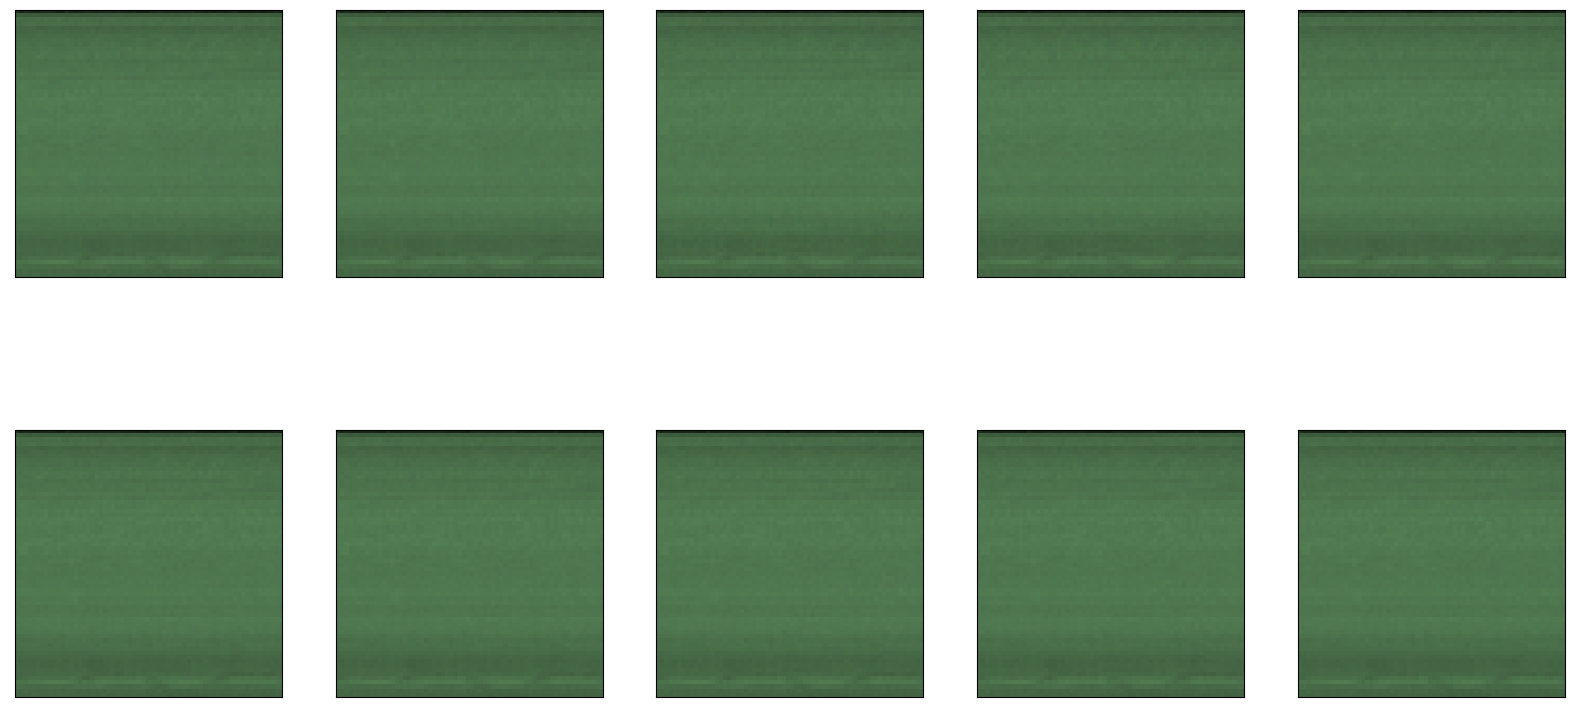

In [27]:
nrows, ncols = 2, 5
# Creating a figure and axes for our plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Declaring a counting variable
counter = 0

# Iterating over the axes and plotting the inferred images in them
for i in range(nrows):
    for j in range(ncols):        
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])
        axes[i, j].imshow(X=x_infer_from_average[counter])

        # Incrementing the counter
        counter += 1

# Showing the plotted axes
plt.show()

## Ataque Adversarial (Evasion)

In [66]:
attack_auto =FastGradientMethod(
    estimator=classifier, 
    eps=0.25
    )

In [13]:
X_train.shape

(7471, 64, 64)

In [14]:
X_test.shape

(1868, 64, 64)

In [14]:
from skimage.transform import resize

In [15]:
X_train = resize(X_train, (7471, 64, 64, 3), mode='constant')
X_test = resize(X_test, (1868, 64, 64, 3), mode='constant')

In [68]:
test_images_adv = attack_auto.generate(x=X_test)

In [69]:
categorical_y_entrenamiento = to_categorical(y_train)
categorical_y_test = to_categorical(y_test)

In [70]:
#Evaluar los modelos
score_clean = model1.evaluate(
    x=X_test, 
    y=categorical_y_test
    )

# Con adversarial
score_adv = model1.evaluate(
    x=test_images_adv, 
    y=categorical_y_test
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.5f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.5f}")

Clean test set loss: 3.06 vs adversarial set test loss: 3.11
Clean test set accuracy: 0.33779 vs adversarial test set accuracy: 0.25642


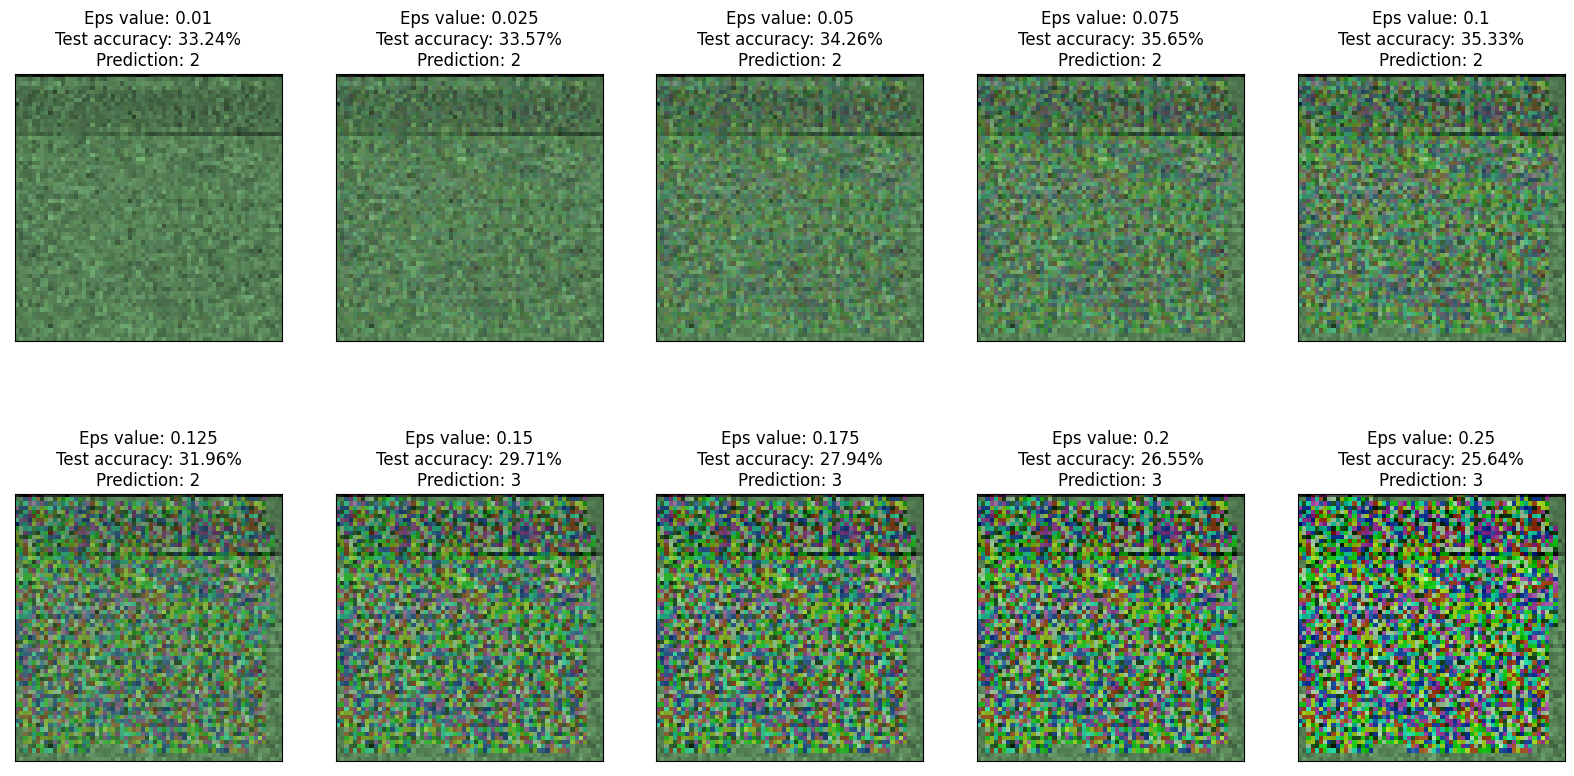

In [71]:
#Se prueba el accuracy para distintos valores de epsilon

# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=classifier, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=X_test)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv, 
            y=categorical_y_test
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model1.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()

## Defensa

In [29]:
X = df['Image'].values
y = df['Family_cat'].values
X = np.array([np.array(xi) for xi in X])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

array([[[  1,   0,   3, ...,   0,   0,   0],
        [ 50,  80,  71, ...,  98,  72,  82],
        [ 43,  57,  47, ...,  51,  45,  42],
        ...,
        [125, 123, 132, ..., 142, 141, 145],
        [115, 120, 112, ..., 112, 124, 110],
        [ 90, 104,  69, ...,  97,  82,  92]],

       [[ 42,  40,  53, ...,  17,  23,  25],
        [ 99,  89,  79, ...,  80,  85,  80],
        [ 81,  81, 146, ..., 113,  90, 156],
        ...,
        [140, 120, 112, ..., 132, 118, 118],
        [118, 123, 112, ..., 134, 132, 136],
        [128, 147, 122, ..., 143, 113, 145]],

       [[ 62,  25,  30, ...,  21,   8,   3],
        [151,  89, 121, ..., 148,  94,  82],
        [174, 143, 126, ..., 151, 126, 103],
        ...,
        [139, 151, 127, ..., 135, 127, 150],
        [114, 132, 129, ..., 107, 136, 149],
        [123, 159, 120, ...,  87, 131, 176]],

       ...,

       [[ 22,  20,  20, ...,  20,  25,  20],
        [101, 102,  98, ..., 117, 104,  98],
        [100, 104,  84, ..., 125, 111, 114

In [30]:
X_train = X_train/255
X_test = X_test/255

In [72]:
classifier = KerasClassifier(
    model=model1,
clip_values= (0.0,1.0))

In [73]:
# Crear un defensor adversarial para el entrenamiento adversarial
detector = BinaryInputDetector(classifier)

In [74]:
is_adv = detector.detect(test_images_adv)

In [75]:
is_adv

({'predictions': array([[0.03530035, 0.03639143, 0.0479742 , ..., 0.03175421, 0.04563439,
          0.04093853],
         [0.03642641, 0.03693304, 0.04788624, ..., 0.03363309, 0.04593932,
          0.04076723],
         [0.03301357, 0.03459944, 0.04400427, ..., 0.03689004, 0.04250959,
          0.04004586],
         ...,
         [0.03651637, 0.03685245, 0.05049095, ..., 0.03202367, 0.04448933,
          0.04059638],
         [0.03663059, 0.03768682, 0.04638686, ..., 0.03374035, 0.04493474,
          0.03961905],
         [0.03508632, 0.03525297, 0.04892887, ..., 0.03146824, 0.04578474,
          0.04066905]], dtype=float32)},
 array([ True,  True,  True, ...,  True,  True,  True]))

In [76]:
predictions = is_adv[0]['predictions']
is_adv_labels = is_adv[1]

In [87]:
predictions

array([[0.03530035, 0.03639143, 0.0479742 , ..., 0.03175421, 0.04563439,
        0.04093853],
       [0.03642641, 0.03693304, 0.04788624, ..., 0.03363309, 0.04593932,
        0.04076723],
       [0.03301357, 0.03459944, 0.04400427, ..., 0.03689004, 0.04250959,
        0.04004586],
       ...,
       [0.03651637, 0.03685245, 0.05049095, ..., 0.03202367, 0.04448933,
        0.04059638],
       [0.03663059, 0.03768682, 0.04638686, ..., 0.03374035, 0.04493474,
        0.03961905],
       [0.03508632, 0.03525297, 0.04892887, ..., 0.03146824, 0.04578474,
        0.04066905]], dtype=float32)

In [78]:
is_adv_labels

array([ True,  True,  True, ...,  True,  True,  True])

In [89]:
accuracy = accuracy_score(y_test, is_adv_labels)
accuracy

0.010171306209850108